In [1]:
%cd ..
%load_ext autoreload

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code


In [2]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
import constants
from statistics_methods.Statistics import StatisticsWrapper
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import xgboost as xgb
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import shap
from statistics_methods.plots import PlotsManager
import numpy as np

/ems/elsc-labs/mezer-a/niv.amos/.conda/envs/qmri/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
chosen_rois_dict = constants.ROI_CORTEX_AND_GRAY_SUB_CORTEX
params_to_work_with = constants.ALL_PARAMS

In [14]:
def load_data(data_path, outliers=[]):
    subjects_raw_data = DataProcessor(data_path, chosen_rois_dict, chosen_rois_dict).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_median_per_subject_per_parameter_per_ROI(subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

    chosen_data = chosen_data[~chosen_data.subjects.isin(outliers)]
    # chosen_data = chosen_data.drop(columns=constants.SLOPES)
    chosen_data['ROI'] = chosen_data['ROI'].astype(str)
    chosen_data['subjects'] = chosen_data['subjects'].astype(str)

    group_a_name, group_b_name, col_divider, threshold = constants.YOUNG, constants.OLD, 'Age', constants.AGE_THRESHOLD
    young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(chosen_data, col_divider, threshold)

    return chosen_data, young_subjects, old_subjects

def show_correlations_stats(all_data, young_data, old_data, method, eval_data=None):
    clusters_rois = StatisticsWrapper.hierarchical_clustering(all_data, params_to_work_with, 'single',
                                                                title="all")['dendrogram_data']['ivl']
    young_result = StatisticsWrapper.roi_correlations(young_data, params_to_work_with, clusters_rois,
                                                        group_title='Correlations of young group', method=method)
    old_result = StatisticsWrapper.roi_correlations(old_data, params_to_work_with, clusters_rois,
                                                     group_title='Correlations of old group', method=method)
                        
    PlotsManager.plot_heatmap(old_result - young_result, 'differences of old and young', project_name=None)
    young_corr_means, old_corr_means  = show_corr_mean(young_result, old_result, clusters_rois, 'Average correlations', eval_data)

def show_corr_mean(young_result, old_result, clusters_rois, title, eval_data):
    young_result['corr_mean'] = young_result.apply(np.mean, axis=1)
    old_result['corr_mean'] = old_result.apply(np.mean, axis=1)
    eval_data_orederd = eval_data.copy()
    eval_data_orederd.index = eval_data_orederd['ROI']
    eval_data_orederd = eval_data_orederd.reindex(clusters_rois)

    fig = plt.figure(figsize=(20, 8))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title(f'{title}')
    ax.scatter(clusters_rois, young_result['corr_mean'].to_numpy(), color='blue', s=20, alpha=0.7, label='young')
    ax.scatter(clusters_rois, old_result['corr_mean'].to_numpy(), color='red', s=20, alpha=0.7, label='old')
    ax.scatter(clusters_rois, eval_data_orederd['Accuracy'], color='black', s=20, alpha=0.7, label='model accuracy', marker='^')
    ax.plot(clusters_rois, eval_data_orederd['Accuracy'], color='black')
    ax.plot(clusters_rois, young_result['corr_mean'].to_numpy(), color='blue')
    ax.plot(clusters_rois, old_result['corr_mean'].to_numpy(), color='red')

    ax.set_xticks(clusters_rois)
    ax.set_xticklabels(clusters_rois, rotation='vertical', fontsize=10)

    # Connecting the points with vertical lines
    for x, y1, y2 in zip(clusters_rois, young_result['corr_mean'].to_numpy(), old_result['corr_mean'].to_numpy()):
        plt.plot([x, x], [y1, y2], color='gray', linestyle='--')
        
    # ax.set_facecolor('white')
    ax.legend()
    ax.grid(True)

    return young_result['corr_mean'], old_result['corr_mean']

def create_evaluation_report(data, y_test, y_pred):
    # Add predictions to the test dataset
    test_results = data.copy()
    test_results["predicted_label"] = y_pred
    test_results["label"] = y_test

    # Group by name and calculate evaluation metrics for each group
    name_groups = test_results.groupby("ROI_name")
    evaluation_results = []

    for name, group in name_groups:
        true_labels = group["label"]
        predicted_labels = group["predicted_label"]
        
        evaluation_results.append({
            "ROI": name,
            "Accuracy": accuracy_score(true_labels, predicted_labels),
            "Precision": precision_score(true_labels, predicted_labels),
            "Recall": recall_score(true_labels, predicted_labels),
            "F1-score": f1_score(true_labels, predicted_labels)
        })

    # Convert evaluation results to DataFrame for easier visualization
    evaluation_df = pd.DataFrame(evaluation_results)
    return evaluation_df

In [15]:
outliers = ['H047_DC', 'H036_EV', 'H054_AE', 'H046_NB']
# outliers = []
chosen_data_raw, young_subjects_raw, old_subjects_raw = load_data(constants.PATH_TO_CORTEX_AND_GRAY_SUB_CORTEX_all_params_raw, outliers=outliers)
chosen_data_z_score, young_subjects_z_score, old_subjects_z_score = load_data(constants.PATH_TO_CORTEX_AND_GRAY_SUB_CORTEX_all_params_z_score, outliers=outliers)

# Cortex binary classification

In [16]:
data = chosen_data_raw.copy()
seed = 42
young_mask = young_subjects_raw.index
old_mask = old_subjects_raw.index

# Assign labels directly to data_reduced_tsne DataFrame
data.loc[young_mask, 'label'] = 0
data.loc[old_mask, 'label'] = 1

data = data.sample(frac=1)

x, y = data.drop(columns=['label']), data['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=data['ROI_name'], random_state=seed)

In [17]:
model = xgb.XGBClassifier(random_state=seed)
model.fit(x_train[params_to_work_with], y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=42, ...)

In [18]:
#Making predictions on the test set
predictions = model.predict(x_test[params_to_work_with])

#Calculating accuracy
accuracy = accuracy_score(y_test, predictions)

print("Accuracy:", accuracy)
print("\nClassification Report:")
print(classification_report(y_test, predictions, target_names=['young', 'old']))

Accuracy: 0.8944954128440367

Classification Report:
              precision    recall  f1-score   support

       young       0.91      0.89      0.90       238
         old       0.87      0.90      0.89       198

    accuracy                           0.89       436
   macro avg       0.89      0.89      0.89       436
weighted avg       0.90      0.89      0.89       436



/ems/elsc-labs/mezer-a/niv.amos/.conda/envs/qmri/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/ems/elsc-labs/mezer-a/niv.amos/.conda/envs/qmri/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/ems/elsc-labs/mezer-a/niv.amos/.conda/envs/qmri/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1609: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, "true nor predicted", "F-score is", len(true_sum

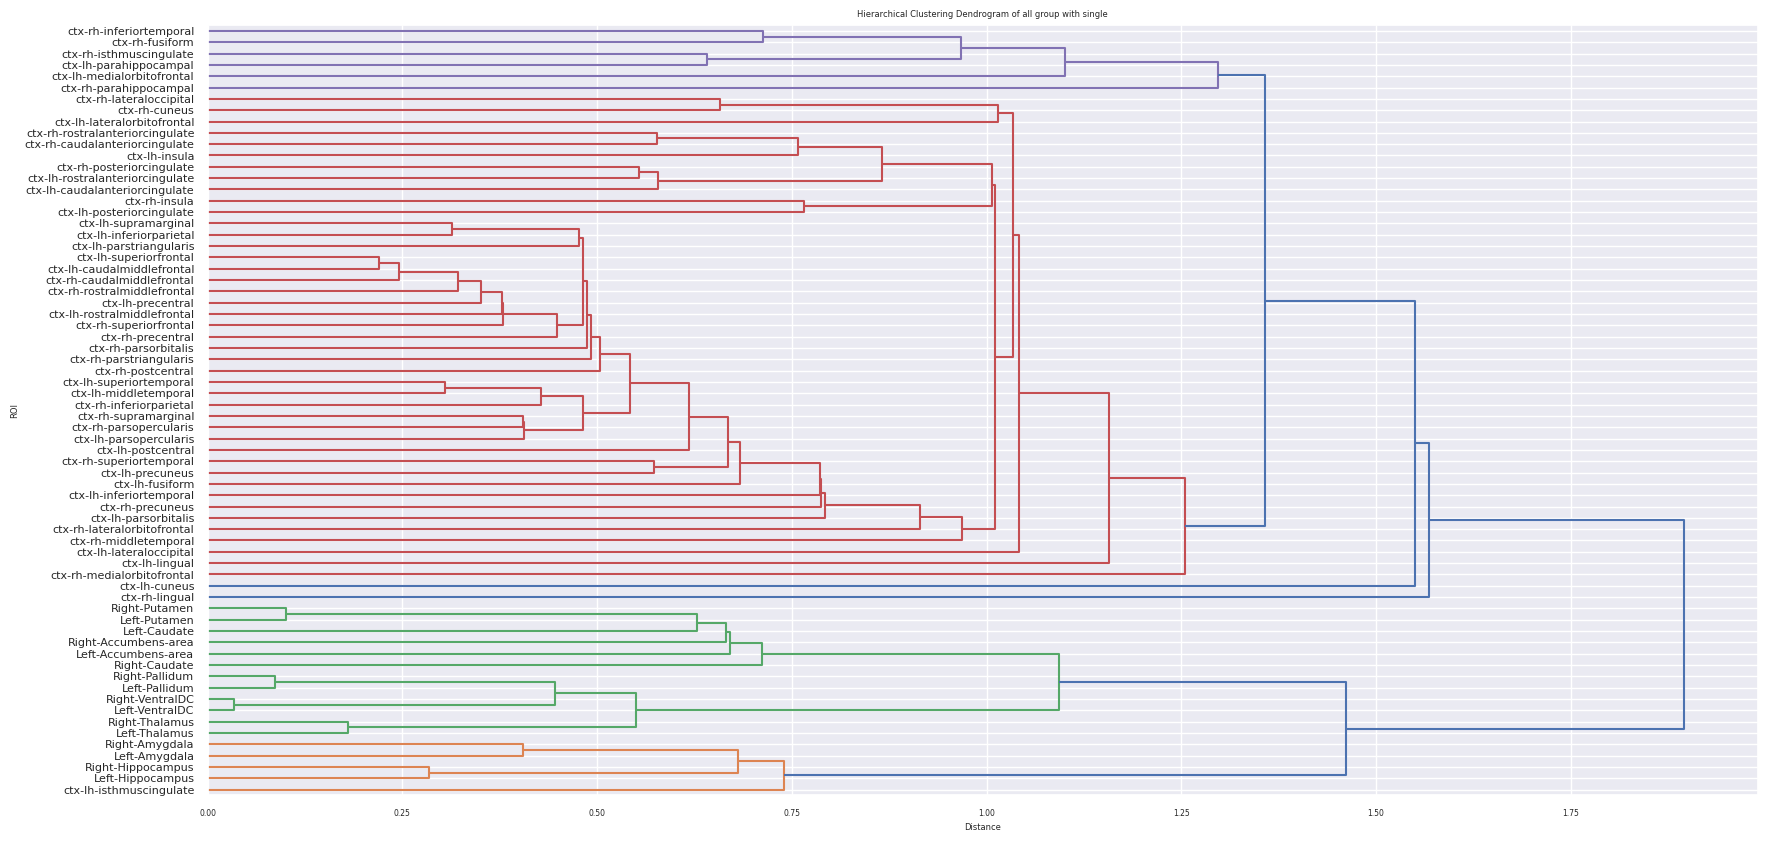

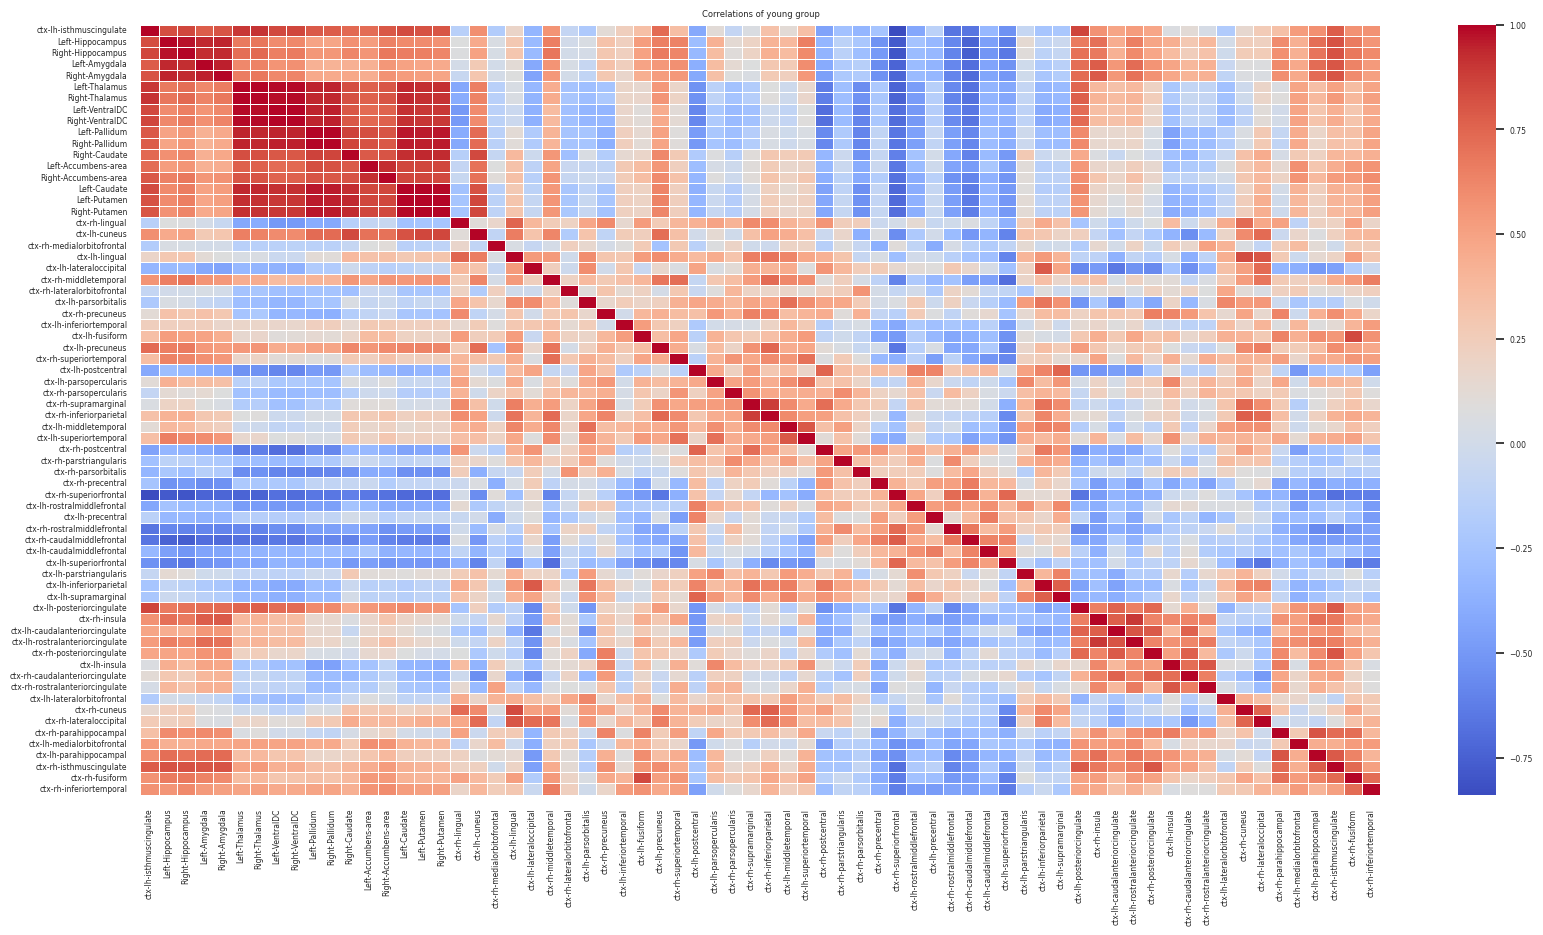

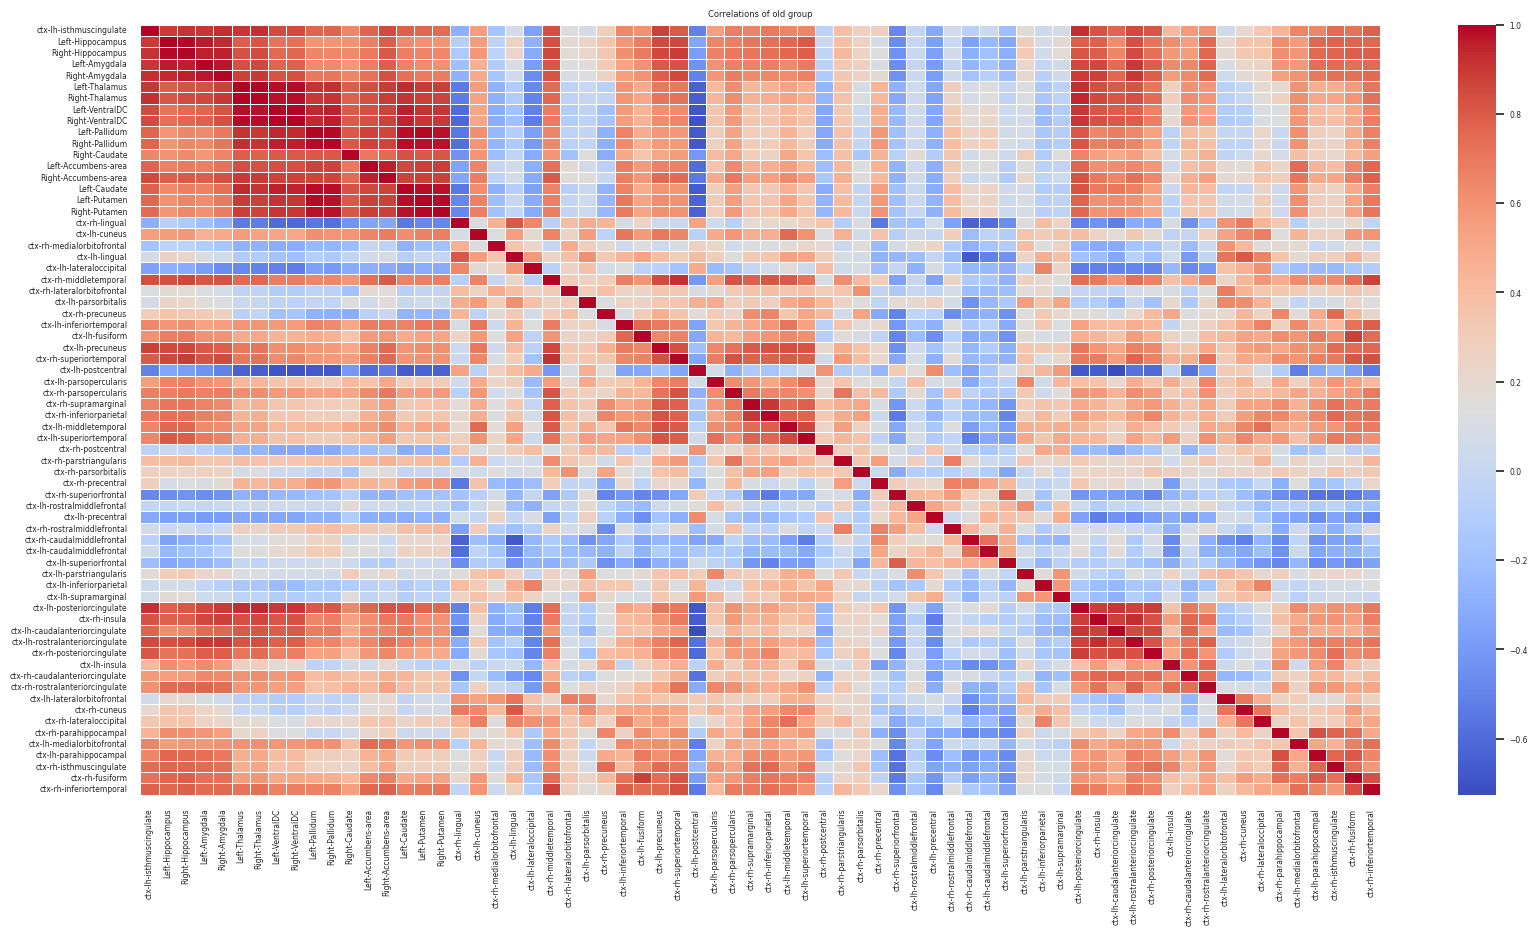

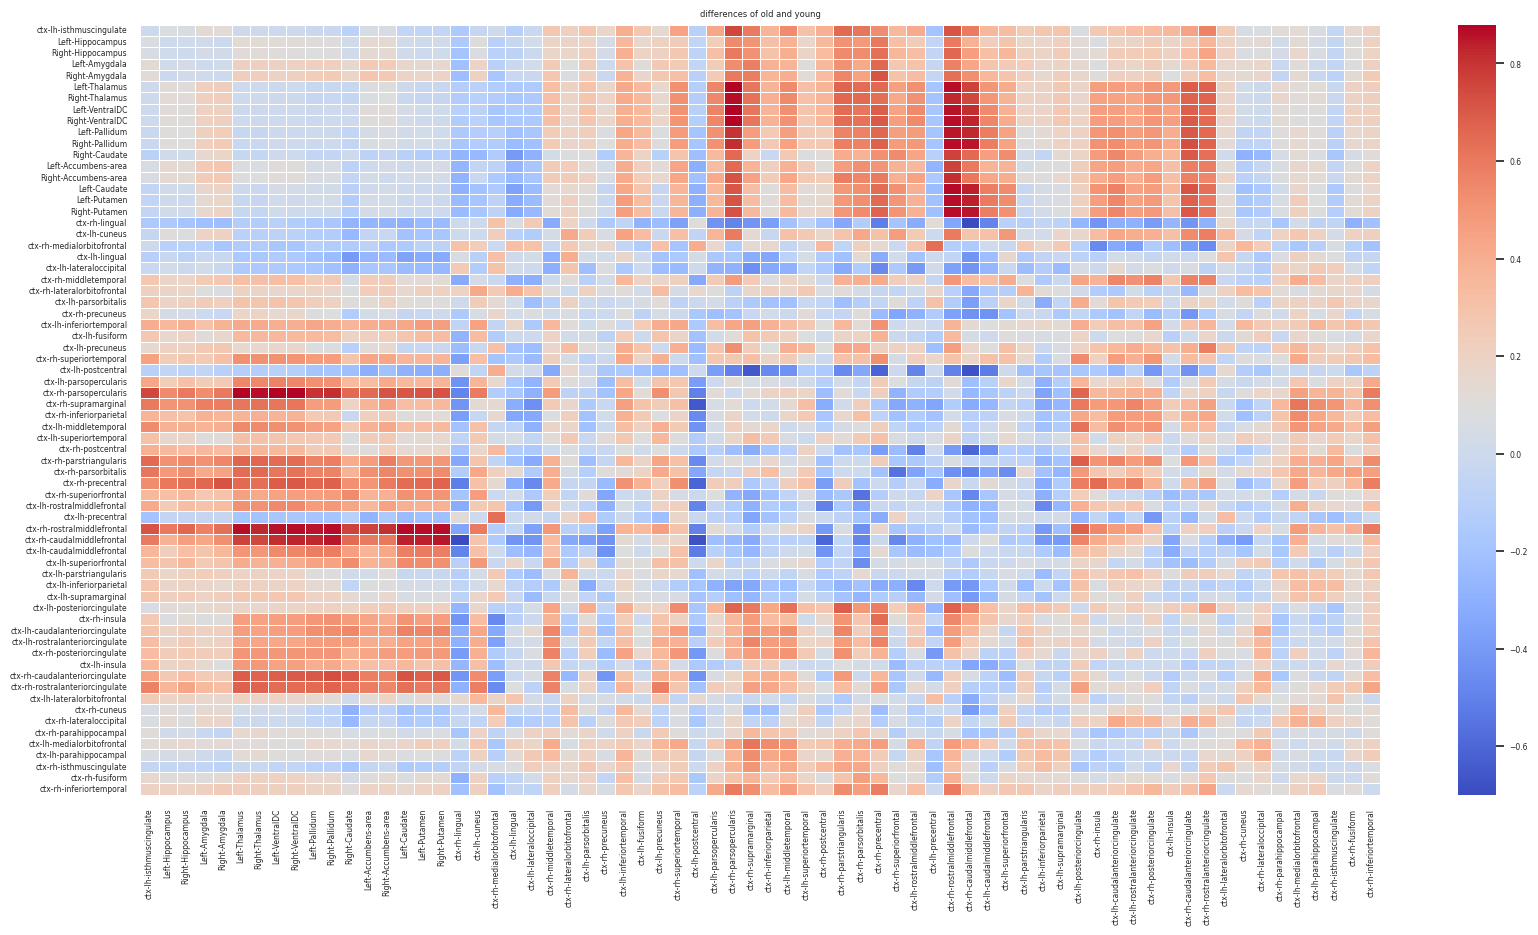

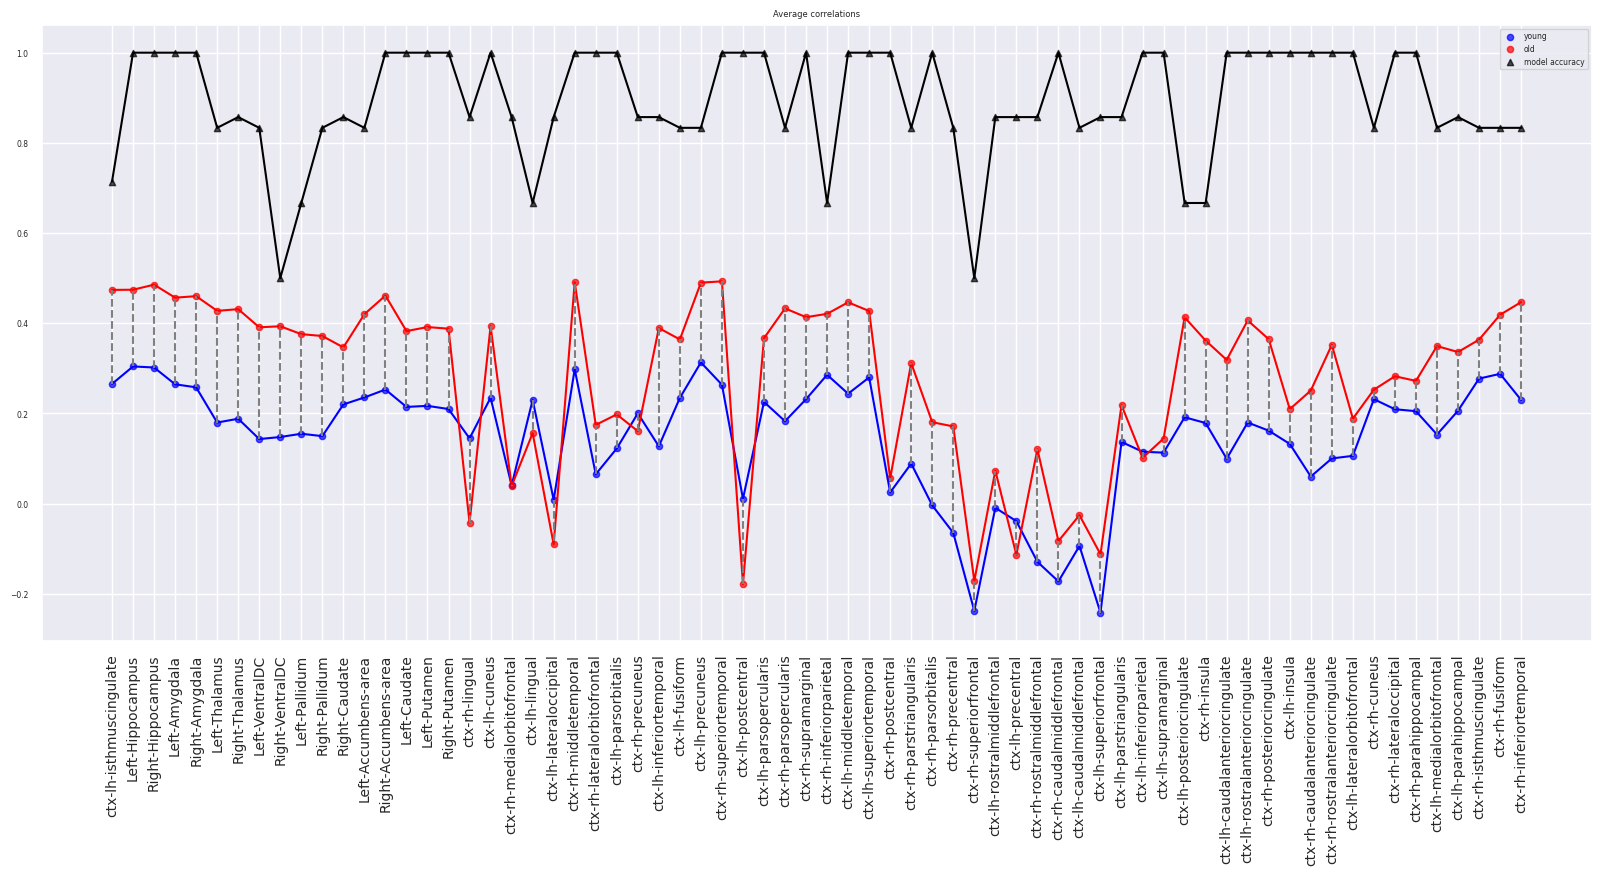

In [19]:
eval_df = create_evaluation_report(x_test, y_test, predictions)
show_correlations_stats(chosen_data_z_score, young_subjects_z_score, old_subjects_z_score, 'pearson', eval_df)

## Features analysis

<BarContainer object of 7 artists>

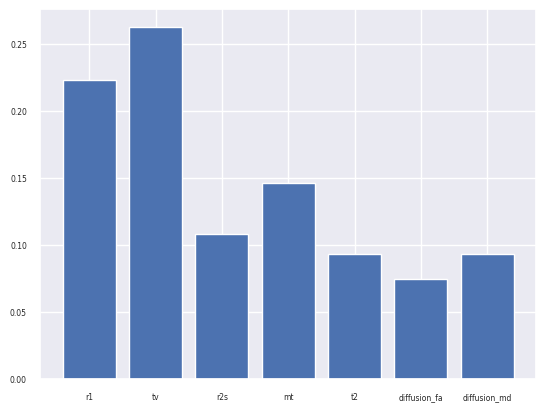

In [20]:
plt.bar(params_to_work_with, model.feature_importances_)

## Age prediction

In [21]:
random_state = 42
data = chosen_data_raw.copy()
data = data.sample(frac=1, random_state=random_state)
x, y, rois_names = data[params_to_work_with], data['Age'], data['ROI_name']

In [22]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)
model = xgb.XGBRegressor(random_state=random_state)

In [23]:
model.fit(x_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [24]:
predictions = model.predict(x_test)
print(list(zip(predictions, y_test)))
# Calculating Mean Absolute Error
mae = mean_absolute_error(y_test, predictions)

print("Mean Absolute Error:", mae)

[(29.227793, 29), (56.750786, 24), (34.367367, 25), (56.112747, 26), (31.887161, 69), (46.699753, 68), (66.51939, 57), (69.64407, 71), (55.96376, 57), (73.015656, 71), (44.313286, 25), (29.696732, 26), (20.348778, 25), (45.554226, 24), (63.623318, 70), (26.29152, 25), (67.10883, 68), (24.507908, 26), (24.974432, 26), (56.09612, 31), (47.05433, 27), (30.169882, 24), (28.26095, 27), (63.181065, 61), (57.74198, 31), (43.47788, 25), (74.78994, 75), (50.22778, 31), (26.51723, 23), (74.73445, 69), (32.250294, 25), (59.798084, 57), (66.18581, 69), (45.387436, 75), (41.085537, 26), (39.22642, 31), (72.445015, 71), (55.33718, 24), (29.326616, 26), (33.04506, 65), (53.72798, 68), (33.054207, 24), (28.263346, 29), (73.33838, 69), (60.39007, 67), (70.004326, 61), (66.3268, 57), (29.375412, 25), (17.34248, 29), (66.06355, 70), (48.028187, 70), (26.396782, 23), (42.785965, 75), (24.339771, 27), (37.187588, 25), (53.741684, 73), (33.03984, 27), (63.984993, 57), (59.709312, 75), (24.699604, 25), (51.6

<BarContainer object of 7 artists>

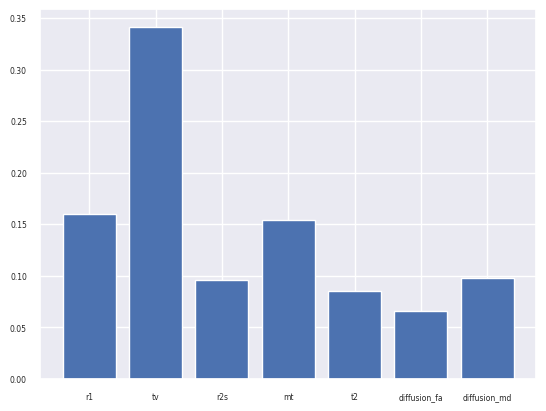

In [25]:
plt.bar(params_to_work_with, model.feature_importances_)

## Params prediction

In [29]:
random_state = 42
param_to_predict = 'r1'
data = chosen_data_raw.copy()
data = data.sample(frac=1, random_state=random_state)
x, y, rois_names = data[params_to_work_with], data[param_to_predict], data['ROI_name']

In [30]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=random_state)
model = xgb.XGBRegressor(random_state=random_state)

In [28]:
model.fit(x_train, y_train)
predictions = model.predict(x_test)
print(list(zip(predictions, y_test)))

# Calculating Mean Absolute Error
mae = mean_absolute_error(y_test, predictions)

print("Mean Absolute Error:", mae)

[(0.59919757, 0.6006250381469727), (0.889054, 0.8818674087524414), (0.89084154, 0.8912742435932159), (0.6658498, 0.6653530597686768), (0.6552502, 0.6555548906326294), (0.6389499, 0.6386772990226746), (0.6831213, 0.6833791434764862), (0.6666709, 0.6662809252738953), (0.8049369, 0.8087463676929474), (0.64123774, 0.6409156620502472), (1.0467641, 1.0450968742370605), (0.6839359, 0.6844482421875), (0.6767253, 0.6769216954708099), (0.6239834, 0.6239824891090393), (0.648835, 0.6489180028438568), (0.6763501, 0.6768380105495453), (0.6683521, 0.6690695285797119), (0.67612123, 0.676402747631073), (1.0619751, 1.059139370918274), (0.68076617, 0.68050217628479), (0.6959886, 0.695618063211441), (0.6200699, 0.6196699738502502), (0.66154426, 0.6616135835647583), (0.7063605, 0.7078815996646881), (1.0971406, 1.1049270033836365), (0.6930488, 0.6925645470619202), (0.75587183, 0.7579416036605835), (0.64441216, 0.6449427008628845), (0.64460367, 0.645470917224884), (0.617729, 0.6179668307304382), (0.6620545, 

<AxesSubplot: >

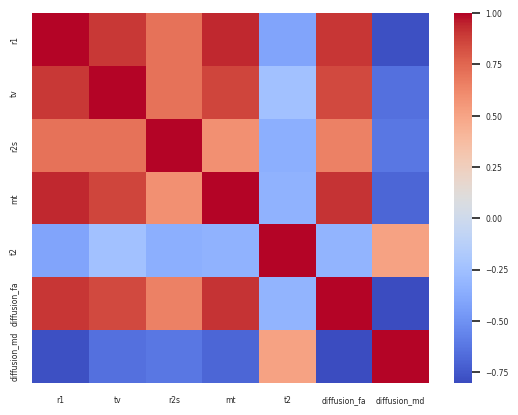

In [32]:
sns.heatmap(data[params_to_work_with].corr(), cmap='coolwarm')